week 4: applied data science capstone part 1 of 2
=================================================

***Using foursquare api to predict the best location for a new Japanese restaurant in Groningen***

**Author:** *Alex de Vries*

### Background
This report will discuss the possibilities of setting up a new Japanese restaurant in the Dutch city of Groningen. This is a student city of around 300.000 people. Because of the university there are students from all over the world. This is not completely represented by the variety of food places in the city. There are two Japanese resaurants that I personaly know of (before starting this analysis). We will find out how many there already are and what the best location would be if someone would want to start a new Japanese restaurant in Groningen. The insights resulting from this analysis could be used for a future business plan.

### Problem
The goal of this analysis is in the end give advise on what the best location for a new Japanese restaurant will be. Because of the limited knowledge of Dutch people regarding Japanese food, any places related to Japanese food will be considered in this analysis. We might even consider Korean food places as any new Japanese place would likely not want to be close to Korean places as it would detract customers. Chinese restaurants are well known and distinquisable for Dutch people so we can leave those out of the analysis.

### Data
This notebook is highly inspirated by the template given in the course. I will keep the idea of clustering the city by area and then plot heatmap to find better area.

I will change some data:
- Country: The Netherlands
- City: Groningen
- Goal: Open a Japanese restaurant/little shop
- So, I will cross data from working days, and localisations.

The following API will be used:
- Foursquare API: to find restaurant/venues
- Google API: reverse geolocalisation

### Library importing


The first step is importing the relevant libraries.
Before importing the libraries an account on foursqueare was created which enables importing geo location data. THis is then analysed using various libraries such as Pandas, Folium, Requests, Math and Shapely.

In [121]:
# This file contains all the ids for foursquare
CLIENT_ID = "UMAV1KOHI434GBVBGDRXLGTXU211YJLCRJ4PJKFZUFDXQV5J"
CLIENT_SECRET = "GZXF3NDHNN2GBQTOYMO2TIWM2QQAW2WIL12CY5FLYGLSMDQT"
VERSION = "20180605"

!pip install folium
# Others imports:
from IPython.display import Image
import pickle
import json
import requests
import folium
import pandas as pd
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from matplotlib import pyplot as plt
!pip install shapely
import shapely.geometry

!pip install pyproj
import pyproj
import math

import warnings
warnings.simplefilter("ignore")
print('importing completed')

%matplotlib inline

importing completed


### Methodology

In the Methodology section the data is imported, organised and analysed. The longitude and latitude of Groningen is aquired from Google Maps. The radius value is set to 600 based on testing to cover the relevant area. Tese values including the Foursquare secret ID and version are combined in a Foursquare API call. 

In [151]:
groningen_latitude = 53.219383
groningen_longitude = 6.566502
groningen_coords = (groningen_latitude,groningen_longitude)
radius = 600
LIMIT = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    groningen_latitude, 
    groningen_longitude, 
    radius, 
    LIMIT)
print('Coordinates of Groningen: {}'.format(groningen_coords))

Coordinates of Groningen: (53.219383, 6.566502)


In [152]:
results = requests.get(url).json()

The next step after saving the results of the API call is structuring the data in a new dataframe. It will contain two columns with the names 'name' and 'categories'. 
The step after that is to add two new columns to the table for latitude and longitude. The values are find using the following code for each venue and saved in the dataframe.

In [153]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [154]:
venues = results['response']['groups'][0]['items']  

grunn_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.crossStreet', 'venue.location.lat', 'venue.location.lng']
grunn_venues =grunn_venues.loc[:, filtered_columns]

# filter the category for each row
grunn_venues['venue.categories'] = grunn_venues.apply(get_category_type, axis=1)

# clean columns
grunn_venues.columns = [col.split(".")[-1] for col in grunn_venues.columns]
grunn_venues.head()


,name,categories,crossStreet,lat,lng
0,Pure Groningen,Frozen Yogurt Shop,Koude Gat,53.217708,6.566397
1,Der Witz,Bar,NaN,53.218259,6.567054
2,Mr. Mofongo,Restaurant,Academieplein,53.219369,6.564100
3,Gustatio,Italian Restaurant,NaN,53.218200,6.568896
4,Cho Fah Eatthai,Thai Restaurant,NaN,53.217775,6.568035


In [155]:
print('{} venues were returned by Foursquare.'.format(grunn_venues.shape[0]))

100 venues were returned by Foursquare.


In [156]:
#Now seperate all venues in different tables so we can plot them with different colors in the folium.map.
restaurant_venues = grunn_venues[grunn_venues['categories'].str.contains('Restaurant')]
cafe_venues = grunn_venues[grunn_venues['categories'].str.contains('Café')]
place_venues = grunn_venues[grunn_venues['categories'].str.contains('Place')]
shop_venues = grunn_venues[grunn_venues['categories'].str.contains('Shop')]
bar_venues = grunn_venues[grunn_venues['categories'].str.contains('Bar')]
cafe_venues.shape[0]

total_venues = pd.DataFrame(columns=['Restaurants', 'Cafes', 'Places', 'Shops' ,'Bars'])
total_venues = total_venues.append({'Restaurants': restaurant_venues.shape[0] , 
                                    'Cafes': cafe_venues.shape[0], 
                                    'Places': place_venues.shape[0], 
                                    'Shops': shop_venues.shape[0], 
                                    'Bars': bar_venues.shape[0]}, 
                                    ignore_index=True)
print('removing non food venues, the remaining venues are shown as follows:')
dining_list = [restaurant_venues, cafe_venues, place_venues, shop_venues, bar_venues]
dining_df =pd.concat(dining_list)

total_venues

removing non food venues, the remaining venues are shown as follows:


,Restaurants,Cafes,Places,Shops,Bars
0,26,6,7,9,8


### Results

In [157]:
#grunn_venues.name
groningen_map = folium.Map(location=[groningen_latitude, groningen_longitude], zoom_start=15) # generate map centered around the Conrad Hotel

# add the restaurants as red circle markers
for lat, lng, label in zip(restaurant_venues.lat, restaurant_venues.lng, Restaurant_venues.name):
    folium.CircleMarker([lat, lng],radius=5, color='red', popup=label, fill = True, fill_color='red', fill_opacity=0.6
    ).add_to(groningen_map)

# add the Cafes as blue circle markers
for lat, lng, label in zip(cafe_venues.lat, cafe_venues.lng, cafe_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='blue', popup=label, fill = True, fill_color='blue', fill_opacity=0.6
    ).add_to(groningen_map)

# add the places as green circle markers
for lat, lng, label in zip(place_venues.lat, place_venues.lng, place_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='green', popup=label, fill = True, fill_color='green', fill_opacity=0.6
    ).add_to(groningen_map)
    
# add the restaurants as purple circle markers
for lat, lng, label in zip(shop_venues.lat, shop_venues.lng, shop_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='purple', popup=label, fill = True, fill_color='purple', fill_opacity=0.6
    ).add_to(groningen_map)    

# add the bars as yellow circle markers
for lat, lng, label in zip(bar_venues.lat, bar_venues.lng, bar_venues.name):
    folium.CircleMarker([lat, lng], radius=5, color='yellow', popup=label, fill = True, fill_color='yellow', fill_opacity=0.6
    ).add_to(groningen_map)
    
# display map
groningen_map

In [158]:
#kmeans
grunn_df = dining_df.copy()
grunn_df.drop(['name', 'categories', 'crossStreet'], axis ='columns', inplace = True)

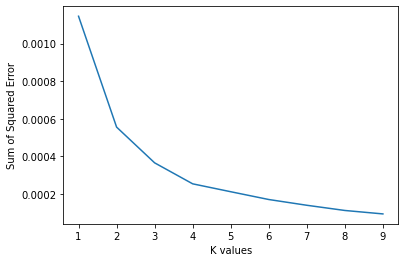

In [159]:
sse = []
k_range = range(1,10)
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(grunn_df)
    sse.append(km.inertia_)

    
plt.xlabel('K values')
plt.ylabel('Sum of Squared Error')
plt.plot(k_range, sse)

In [166]:
km = KMeans(n_clusters=4)
cluster = km.fit_predict(grunn_df)
dining_df['cluster'] = cluster
dining_df.head()

,name,categories,crossStreet,lat,lng,cluster
2,Mr. Mofongo,Restaurant,Academieplein,53.219369,6.564100,0
3,Gustatio,Italian Restaurant,NaN,53.218200,6.568896,1
4,Cho Fah Eatthai,Thai Restaurant,NaN,53.217775,6.568035,1
20,Imono,Sushi Restaurant,NaN,53.217628,6.568279,1
21,Osteria Da Vinci,Italian Restaurant,NaN,53.221979,6.567679,2


In [170]:
df1 = dining_df[dining_df.cluster == 0]
df2 = dining_df[dining_df.cluster == 1]
df3 = dining_df[dining_df.cluster == 2]
df4 = dining_df[dining_df.cluster == 3]

In [171]:
groningen2_map = folium.Map(location=[groningen_latitude, groningen_longitude], zoom_start=15) # generate map centered around the Conrad Hotel

# the for loops make it not work for some reason.
for lat, lng, label in zip(df1.lat, df1.lng, df1.name):
    folium.CircleMarker([lat, lng],radius=5, color='red', popup=label, fill = True, fill_color='red', fill_opacity=0.6
    ).add_to(groningen2_map)
    
for lat, lng, label in zip(df2.lat, df2.lng, df2.name):
    folium.CircleMarker([lat, lng], radius=5, color='blue', popup=label, fill = True, fill_color='blue', fill_opacity=0.6
    ).add_to(groningen2_map)

for lat, lng, label in zip(df3.lat, df3.lng, df3.name):
    folium.CircleMarker([lat, lng], radius=5, color='green', popup=label, fill = True, fill_color='green', fill_opacity=0.6
    ).add_to(groningen2_map)

for lat, lng, label in zip(df4.lat, df4.lng, df4.name):
    folium.CircleMarker([lat, lng], radius=5, color='purple', popup=label, fill = True, fill_color='purple', fill_opacity=0.6
    ).add_to(groningen2_map)
    
groningen2_map


### Discussion
This will be added in part 2

### Conclusion
This will be added in part 2